In [2]:
# Libraries
import numpy as np
from numpy.fft import fftn, ifftn, fftshift
import matplotlib.pyplot as plt
import os
import imageio
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import root_scalar
from scipy.integrate import quad

#### **The model description**:
##### $\blacksquare$ Considering two independent, motion invariant, i.e. stationary and isotropic, Gaussian random fields $X={X(t):t \in \mathbb{R}^3}$ and $Y={Y(t):t \in \mathbb{R}^3}$, with covariance functions $\rho_{X}$ and $\rho_{Y}$. Moreover, $\mathbb{E}X(t) = \mathbb{E}Y(t) = 0$ and $\mathrm{Var}X(t) = \mathrm{Var}Y(t) = 1$ for all $t \in \mathbb{R}^3$
##### $\blacksquare$ A third random field $Z = {Z(t):t \in \mathbb{R}^3}$, given by $Z(t) = \sqrt{m} X(t) + \sqrt{1-m} Y(t)$, is considered for each $t \in \mathbb{R}^3$, where $m \in [0, 1]$ is a certain weight parameter (in this case for three facies).
##### $\blacksquare$ Two futher threshold parameters for two random field as $\lambda_X$, $\lambda_Y$ $\in \mathbb{R}$, we defined three random sets $\Xi_1$, $\Xi_2$ and $\Xi_3$ by $\Xi_1 = {t \in \mathbb{R}^3:X(t) \geq \lambda_X}$, $\Xi_2 = \{t \in \mathbb{R}^3:Z(t) \geq \lambda_Z\} \cap \Xi_{1}^c$ and $\Xi_3 = (\Xi_1 \cup \Xi_2)^c$
##### $\blacksquare$ For each $i \in {1, 2, 3}$, we denote the volume fraction of the $i$-th phase by $\varepsilon_i$, i.e. $\varepsilon_i = \mathbb{P} (\circ \in \Xi_i)$, with $\circ$ is the origin in $\mathbb{R}^3$. Then, this is really important to consider **two point covarage probability function** by $C_{ij}$, i.e. $C_{ij}: [0, \infty) \rightarrow [0, 1]$ with $C_{ij} (h) = \mathbb{P} (\circ \in \Xi_i, u \in \Xi_j)$ for each $h \in [0, \infty)$, where $u \in \mathbb{R}^3$ is abitrary vector with $\parallel u \parallel = h$
##### $\blacksquare$ Denote $\varphi (t)$ as the value of the PDF of the standard normal distribution at $t$, and $\Phi(t)$ is CDF. Another parameter we have to notice is **correlation cofficient** $\gamma$, with $-1 < \gamma < 1$. What is correlation coefficient? This value will tell you how much two random variable correlate to each other with the formular as $\gamma = \mathrm{Corr}(X_1, X_2) = \frac{\mathrm{Cov}(X_1, X_2)}{\sigma_{X_1} \sigma_{X_2}}$, with $\mathrm{Cov}(X_1, X_2) = \mathbb{E}[(X_1 - \mathbb{E}[X_1])(X_2 - \mathbb{E}[X_2])]$.
##### $\blacksquare$ So, we have a system of equations as:
###### $\varepsilon_1 = 1 - \Phi(\lambda_X)$ [1]
###### $\varepsilon_2 = \mathbb{P}(\sqrt{m}X(\circ) + \sqrt{1-m}Y(\circ) \ge \lambda_Z, X(\circ) < \lambda_X) = \int_{-\infty}^{\lambda_X} \varphi(t)\big( 1 - \Phi \big( \frac{\lambda_Z - t\sqrt{m}}{\sqrt{1-m}} \big) \big)$ [2]
##### $\blacksquare$ In order to estimate **covariance functions** $\rho_X$, $\rho_Y$ and m, we need to solve the inverse intergral of tge euation [3] below, for each $h \geq 0$:
###### $C_{11} (h) = \varepsilon^{2}_1 + \int^{\rho_{X} (h)}_{0} \varphi(\lambda_X, \lambda_X, \gamma)d\gamma$ [3]
##### $\blacksquare$ Furthermore, $C_{22}$ and $C_{12}$ can be expressed by $\lambda_X$, $\lambda_Y$, $\rho_X$ and $\rho_Y$. Let $u \in \mathbb{R}^3$ be an arbitrary vector of length $h$. We have two equations [4] and [5] as
###### $C_{22} (h) = \mathbb{P}(\sqrt{m}X(\circ) + \sqrt{1-m}Y(\circ) \ge \lambda_Z, X(\circ) < \lambda_X, \sqrt{m}X(u) + \sqrt{1-m}Y(u) \ge \lambda_Z, X(u) < \lambda_X) = \int^{\lambda_X}_{-\infty} \int^{\lambda_X}_{-\infty} \varphi(s, t, \rho_X (h)) \int^{\infty}_{\frac{\lambda_Z - s\sqrt{m}}{\sqrt{1-m}}} \int^{\infty}_{\frac{\lambda_Z - t\sqrt{m}}{\sqrt{1-m}}} \varphi(\tilde{s}, \tilde{t}, \rho_{Y} (h))d\tilde{s}d\tilde{t}dsdt$ [4]
###### $C_{12} (h) = \mathbb{P}(\sqrt{m}X(\circ) + \sqrt{1-m}Y(\circ) \ge \lambda_Z, X(\circ) < \lambda_X, X(u) \ge \lambda_X) = \int^{\lambda_X}_{-\infty} \int^{\infty}_{\lambda_X} \varphi(s, t, \rho_X (h)) \big( 1 - \Phi \big( \frac{\lambda_Z - t\sqrt{m}}{\sqrt{1-m}} \big) \big) dsdt$ [5]

In [5]:
# ================================ FUNCTION FOR PLURIGAUSSIAN =======================================
# 1. Calculating the estimators from data including volume fraction of phasese eps_i, two-point coverage probability functions ≡ non-centred covariance functions C_{ii}
def epsilon_V(I):                       # volume fraction
    width, height, depth = I.shape
    a_v = width * height * depth
    a_pore = np.sum(I == 0)
    a_solid = np.sum(I == 1)
    nf = a_pore/a_v
    ns = a_solid/a_v
    return nf, ns

def lambda_i(eps_i):                    # threshold of a phase
    return norm.ppf(eps_i)              # percent point function, i.e., the inverse cumulative distribution function (CDF)


In [6]:
folder_path = r"D:\data\data3d200\5"
# Get a sorted list of all image files (important!)
def extract_number(fname):
    return int(os.path.splitext(fname)[0])

file_list = sorted(
    [f for f in os.listdir(folder_path) if f.endswith(".bmp")],
    key=extract_number
)

# Read first image to get shape
sample = imageio.imread(os.path.join(folder_path, file_list[0]))
H, W = sample.shape
M_pore = np.zeros((len(file_list), H, W), dtype=sample.dtype)
for i, fname in enumerate(file_list):
    M_pore[i] = imageio.imread(os.path.join(folder_path, fname))
M_pore = M_pore.astype(np.uint8)

print("Volume shape:", M_pore.shape)
print("Min value:", M_pore.min())
print("Max value:", M_pore.max())
print("Unique values:", np.unique(M_pore))

C:\Users\phu.thien.nguyen\AppData\Local\Temp\ipykernel_28316\1685673603.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sample = imageio.imread(os.path.join(folder_path, file_list[0]))
C:\Users\phu.thien.nguyen\AppData\Local\Temp\ipykernel_28316\1685673603.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  M_pore[i] = imageio.imread(os.path.join(folder_path, fname))


Volume shape: (200, 200, 200)
Min value: 0
Max value: 1
Unique values: [0 1]


In [7]:
# For pore phase (value = 0):
I_pore = (M_pore == 0).astype(np.uint8)

# For solid phase (value = 1):
I_solid = (M_pore == 1).astype(np.uint8)

In [8]:
eps_0, eps_1 = epsilon_V(I_solid)
print("solidity", eps_0)
print("porosity", eps_1)

solidity 0.776779875
porosity 0.223220125


In [9]:
nx, ny, nz = I_solid.shape

F_omega = fftn(I_solid) # Fourier transform of binary 3d image
print(F_omega.shape)
S_omega = np.abs(F_omega)**2 # PSD from frequency domain function
print(S_omega.shape)
print(S_omega[0,0,0])
R_tau = ifftn(S_omega).real # Autocorrelation function from inverse PSD function. The autocorrelation will be symmetry \rho(\tau) = \rho(-\tau).
#But the FFT will give the matrix wrapped around. mean the the lag tau =0 at the position (0,0,0) of the matrix. in this case it equal to the volume fraction.
print(R_tau.shape)
print(R_tau[0,0,0])
#C_11 = R_tau / (200**3)
C_11 = R_tau / (nx*ny*nz)
print(C_11.shape)
print(C_11.max())
print(C_11[0,0,0])

(200, 200, 200)
(200, 200, 200)
3188942349121.0
(200, 200, 200)
1785761.0
(200, 200, 200)
0.223220125
0.223220125


In [691]:
# ----------------------------------
# Given:
# I_solid : original binary microstructure (Nx,Ny,Nz)
# S_omega : |FFTN(I_solid)|^2
# ----------------------------------

Nx, Ny, Nz = I_solid.shape

n_realizations = 3
realizations = []

for i in range(n_realizations):

    # -----------------------------
    # White noise
    # -----------------------------
    W = np.random.randn(Nx, Ny, Nz)

    # -----------------------------
    # Spectral synthesis
    # -----------------------------
    X = np.real(ifftn(np.sqrt(S_omega) * fftn(W)))

    # Normalize (important!)
    X = (X - X.mean()) / X.std()

    # -----------------------------
    # Threshold to binary
    # -----------------------------
    eps = eps_0
    lambda_thr = norm.ppf(eps)
    I_gen = (X > lambda_thr).astype(np.uint8)

    realizations.append(I_gen)


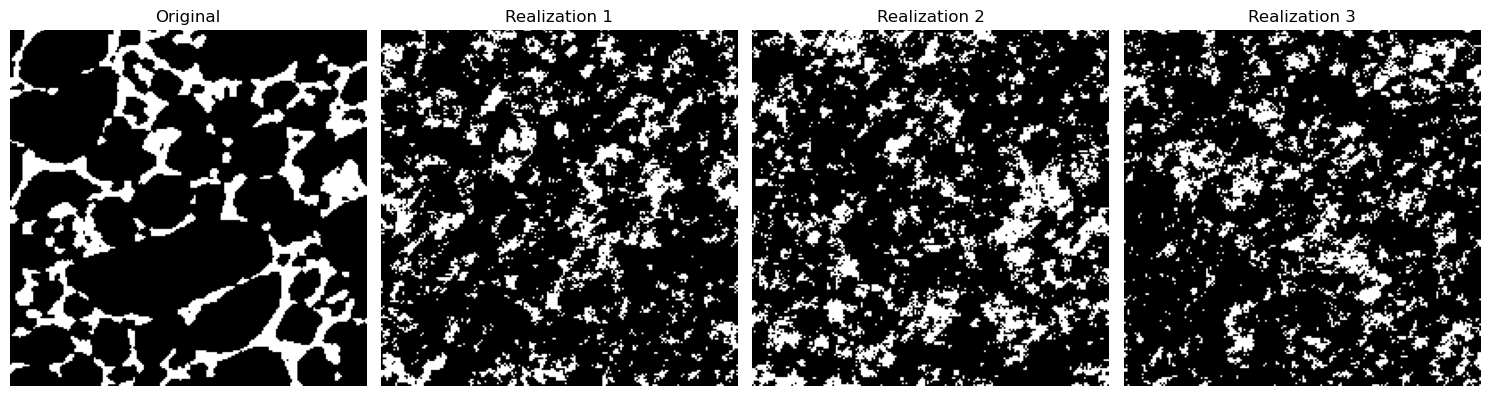

In [692]:
# ----------------------------------
# Visualization
# ----------------------------------
slice_idx = Nx // 2

plt.figure(figsize=(15, 6))

# Original
plt.subplot(1, n_realizations + 1, 1)
plt.imshow(I_solid[slice_idx], cmap='gray')
plt.title("Original")
plt.axis('off')

# Generated realizations
for i, I_gen in enumerate(realizations):
    plt.subplot(1, n_realizations + 1, i + 2)
    plt.imshow(I_gen[slice_idx], cmap='gray')
    plt.title(f"Realization {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


#### We estimated the threshold $\lambda_{1}$ of solid phase, and the covariance function $\rho_{1}$ of solid phase. But we need the covariance as a function of lag $\tau$ (or h in the paper). From that we can generate the underlying gaussian random field from the covariance functions.

In [10]:
# CALCULATE THE THREHOLD AND THE COVARIANCE FUNCTION rho_x
lambda_1 = lambda_i(eps_1)
print(lambda_1)
nx, ny, nz = C_11.shape
Rho_tau = R_tau / (nx*ny*nz) - eps_1**2 # Normalizing the autocorrelation function
print(Rho_tau.shape)
print(Rho_tau[0,0,0])

-0.7613630515515318
(200, 200, 200)
0.17339290079498437


#### We estimated the threshold $\lambda_{1}$ of solid phase, and the covariance function $\rho_{1}$ of solid phase. But we need the covariance as a function of lag $\tau$ (or h in the paper). From that we can generate the underlying gaussian random field from the covariance functions.

C:\Users\phu.thien.nguyen\AppData\Local\Temp\ipykernel_28316\3138021015.py:52: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go--" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(tau_vals, rho_G_11,'go--',  color='blue', marker='o', linewidth=2, label='$\\rho_{11}(\\tau)$', markersize=3)
C:\Users\phu.thien.nguyen\AppData\Local\Temp\ipykernel_28316\3138021015.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(tau_vals, rho_G_11,'go--',  color='blue', marker='o', linewidth=2, label='$\\rho_{11}(\\tau)$', markersize=3)
C:\Users\phu.thien.nguyen\AppData\Local\Temp\ipykernel_28316\3138021015.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(tau_vals, rho_G_22,'g-', color='

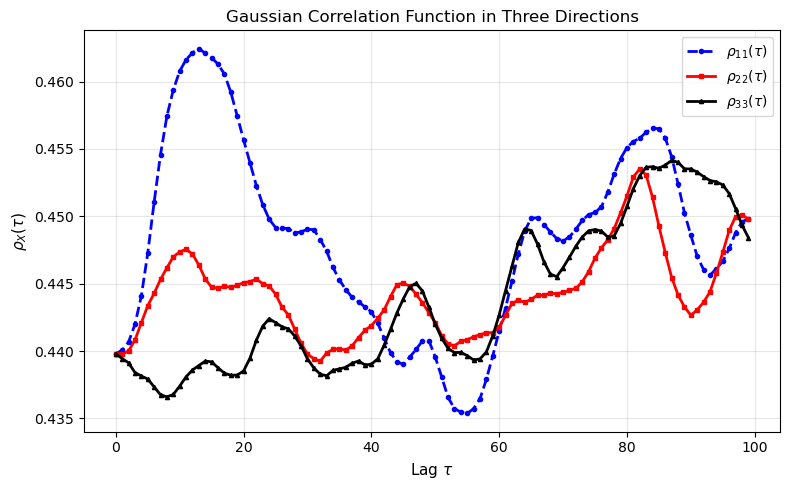

First 10 rho_X values:
h=0: x=0.439799, y=0.439799, z=0.439799
h=1: x=0.440071, y=0.439763, z=0.439447
h=2: x=0.440669, y=0.440013, z=0.439126
h=3: x=0.441980, y=0.440813, z=0.438409
h=4: x=0.444095, y=0.442101, z=0.438153
h=5: x=0.447257, y=0.443368, z=0.437923
h=6: x=0.451046, y=0.444287, z=0.437346
h=7: x=0.454585, y=0.445316, z=0.436753
h=8: x=0.457435, y=0.446181, z=0.436603
h=9: x=0.459387, y=0.446991, z=0.436778


In [14]:

# -----------------------------
# Parameters
# -----------------------------
tau_max = 100  # max lag

nx, ny, nz = C_11.shape
cx, cy, cz = nx//2, ny//2, nz//2 # Need to centered the two point coverage probability, due to the symmatrical one from the autocorrelation function and the FFT output
# cx, cy, cz = 0, 0, 0

# -----------------------------
# Bivariate normal PDF and integral
# -----------------------------
def phi(lambda_1, gamma):
    return 1/(2*np.pi*np.sqrt(1-gamma**2)) * np.exp(-lambda_1**2 * (1-gamma)/(1-gamma**2))

def F(rho):
    integral_val, _ = quad(lambda gamma: phi(lambda_1, gamma), 0, rho)
    return integral_val

F_max = F(0.999)
F_min = 0

# -----------------------------
# Function to compute The correlation function of the latent Gaussian field along a given 1D two point coverage probability function. This is from the intergral
# -----------------------------
def compute_rho_G(C_ii):
    rho_G = []
    for C_val in C_ii:
        target = np.clip(C_val, F_min, F_max)
        sol = root_scalar(lambda rho: F(rho) - target, bracket=[0, 0.999], method='bisect')
        rho_G.append(sol.root)
    return np.array(rho_G)

# -----------------------------
# Extract positive lags along x, y, z
# -----------------------------
C_S_11 = C_11[cx:cx+tau_max , cy, cz]
C_S_22 = C_11[cx, cy:cy+tau_max , cz]
C_S_33 = C_11[cx, cy, cz:cz+tau_max ]

# Compute rho_X for all directions
rho_G_11 = compute_rho_G(C_S_11)
rho_G_22 = compute_rho_G(C_S_22)
rho_G_33 = compute_rho_G(C_S_33)

# -----------------------------
# Plot rho_X(h) in all directions
# -----------------------------
tau_vals = np.arange(tau_max)

plt.figure(figsize=(8,5))
plt.plot(tau_vals, rho_G_11,'go--',  color='blue', marker='o', linewidth=2, label='$\\rho_{11}(\\tau)$', markersize=3)
plt.plot(tau_vals, rho_G_22,'g-', color='red', marker='s', linewidth=2, label='$\\rho_{22}(\\tau)$', markersize=3)
plt.plot(tau_vals, rho_G_33,  color='black', marker='^', linewidth=2, label='$\\rho_{33}(\\tau)$', markersize=3)
plt.xlabel('Lag $\\tau$', fontsize=11)
plt.ylabel('$\\rho_X(\\tau)$', fontsize=11)
plt.title('Gaussian Correlation Function in Three Directions', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# Print first 10 values for each direction
# -----------------------------
print("First 10 rho_X values:")
for tau in range(10):
    print(f"h={tau}: x={rho_G_11[tau]:.6f}, y={rho_G_22[tau]:.6f}, z={rho_G_33[tau]:.6f}")


In [12]:
import numpy as np
from numpy.fft import fftn, ifftn
import matplotlib.pyplot as plt
import os
import imageio
from scipy.stats import norm
from scipy.optimize import root_scalar
from scipy.integrate import quad

# -----------------------------
# Parameters
# -----------------------------
base_folder = r"D:\data\data3d200"
num_folders = 197
tau_max = 100  # max lag along each direction

# -----------------------------
# Functions
# -----------------------------
def epsilon_V(I):
    a_v = np.prod(I.shape)
    a_pore = np.sum(I == 0)
    a_solid = np.sum(I == 1)
    nf = a_pore / a_v
    ns = a_solid / a_v
    return nf, ns

def lambda_i(eps_i):
    return norm.ppf(eps_i)

def phi(lambda_1, gamma):
    return 1/(2*np.pi*np.sqrt(1-gamma**2)) * np.exp(-lambda_1**2 * (1-gamma)/(1-gamma**2))

def F_func(rho, lambda_1):
    integral_val, _ = quad(lambda gamma: phi(lambda_1, gamma), 0, rho)
    return integral_val

def compute_rho_G(C_ii, lambda_1, F_min=0, F_max=0.999):
    rho_G = []
    for C_val in C_ii:
        target = np.clip(C_val, F_min, F_max)
        sol = root_scalar(lambda rho: F_func(rho, lambda_1) - target, bracket=[0, 0.999], method='bisect')
        rho_G.append(sol.root)
    return np.array(rho_G)

def extract_number(fname):
    return int(os.path.splitext(fname)[0])

# -----------------------------
# Storage for all rho curves
# -----------------------------
all_rho_x = []
all_rho_y = []
all_rho_z = []

# -----------------------------
# Loop through all folders
# -----------------------------
for folder_idx in range(1, num_folders+1):
    folder_path = os.path.join(base_folder, str(folder_idx))
    if not os.path.exists(folder_path):
        print(f"Folder {folder_idx} does not exist. Skipping...")
        continue

    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith(".bmp")], key=extract_number)
    if len(file_list) == 0:
        print(f"No images in folder {folder_idx}. Skipping...")
        continue

    # Read images
    sample = imageio.imread(os.path.join(folder_path, file_list[0]))
    H, W = sample.shape
    M_pore = np.zeros((len(file_list), H, W), dtype=sample.dtype)
    for i, fname in enumerate(file_list):
        M_pore[i] = imageio.imread(os.path.join(folder_path, fname))
    M_pore = M_pore.astype(np.uint8)

    I_solid = (M_pore == 1).astype(np.uint8)
    eps_0, eps_1 = epsilon_V(I_solid)
    lambda_1 = lambda_i(eps_1)

    nx, ny, nz = I_solid.shape
    F_omega = fftn(I_solid)
    S_omega = np.abs(F_omega)**2
    R_tau = ifftn(S_omega).real
    C_11 = R_tau / (nx*ny*nz)

    # Center indices
    cx, cy, cz = nx//2, ny//2, nz//2

    # Extract positive lags
    C_S_11 = C_11[cx:cx+tau_max, cy, cz]
    C_S_22 = C_11[cx, cy:cy+tau_max, cz]
    C_S_33 = C_11[cx, cy, cz:cz+tau_max]

    # Compute rho_G
    rho_G_11 = compute_rho_G(C_S_11, lambda_1)
    rho_G_22 = compute_rho_G(C_S_22, lambda_1)
    rho_G_33 = compute_rho_G(C_S_33, lambda_1)

    # Store
    all_rho_x.append(rho_G_11)
    all_rho_y.append(rho_G_22)
    all_rho_z.append(rho_G_33)

    print(f"Folder {folder_idx} processed.")

all_rho_x = np.array(all_rho_x)
all_rho_y = np.array(all_rho_y)
all_rho_z = np.array(all_rho_z)

# -----------------------------
# Plot all curves together
# -----------------------------
tau_vals = np.arange(tau_max)

C:\Users\phu.thien.nguyen\AppData\Local\Temp\ipykernel_28316\991131531.py:71: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sample = imageio.imread(os.path.join(folder_path, file_list[0]))
C:\Users\phu.thien.nguyen\AppData\Local\Temp\ipykernel_28316\991131531.py:75: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  M_pore[i] = imageio.imread(os.path.join(folder_path, fname))


Folder 1 processed.
Folder 2 processed.
Folder 3 processed.
Folder 4 processed.
Folder 5 processed.
Folder 6 processed.
Folder 7 processed.
Folder 8 processed.
Folder 9 processed.
Folder 10 processed.
Folder 11 processed.
Folder 12 processed.
Folder 13 processed.
Folder 14 processed.
Folder 15 processed.
Folder 16 processed.
Folder 17 processed.
Folder 18 processed.
Folder 19 processed.
Folder 20 processed.
Folder 21 processed.
Folder 22 processed.
Folder 23 processed.
Folder 24 processed.
Folder 25 processed.
Folder 26 processed.
Folder 27 processed.
Folder 28 processed.
Folder 29 processed.
Folder 30 processed.
Folder 31 processed.
Folder 32 processed.
Folder 33 processed.
Folder 34 processed.
Folder 35 processed.
Folder 36 processed.
Folder 37 processed.
Folder 38 processed.
Folder 39 processed.
Folder 40 processed.
Folder 41 processed.
Folder 42 processed.
Folder 43 processed.
Folder 44 processed.
Folder 45 processed.
Folder 46 processed.
Folder 47 processed.
Folder 48 processed.
F

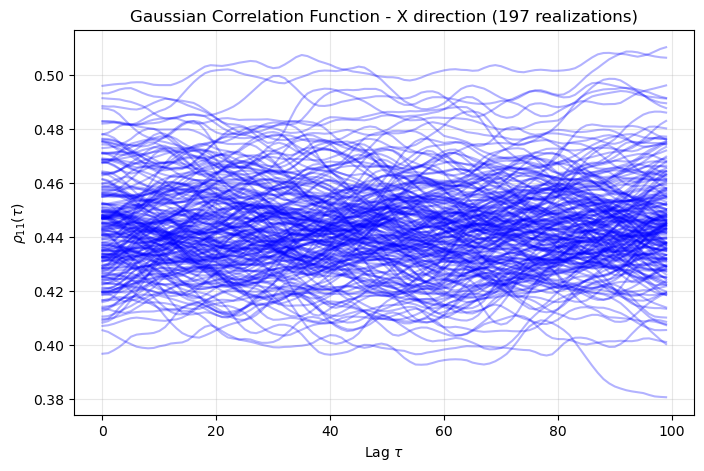

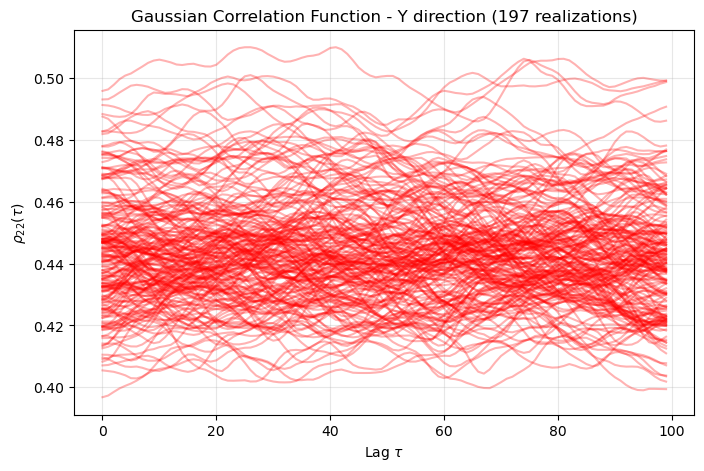

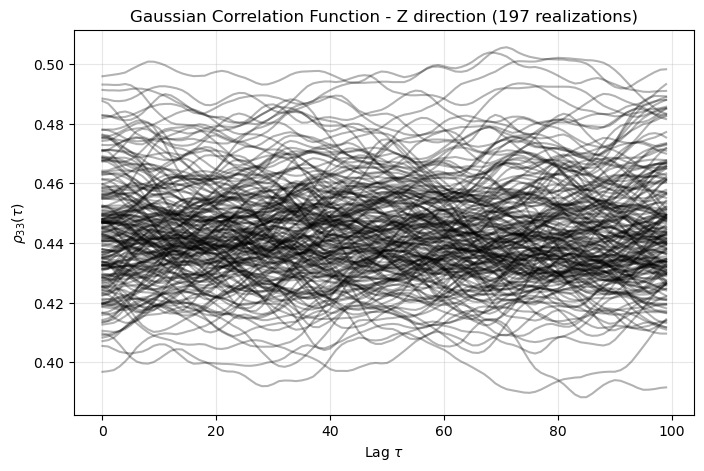

In [13]:
plt.figure(figsize=(8,5))
for i in range(all_rho_x.shape[0]):
    plt.plot(tau_vals, all_rho_x[i], color='blue', alpha=0.3)
plt.xlabel('Lag $\\tau$')
plt.ylabel('$\\rho_{11}(\\tau)$')
plt.title('Gaussian Correlation Function - X direction (197 realizations)')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8,5))
for i in range(all_rho_y.shape[0]):
    plt.plot(tau_vals, all_rho_y[i], color='red', alpha=0.3)
plt.xlabel('Lag $\\tau$')
plt.ylabel('$\\rho_{22}(\\tau)$')
plt.title('Gaussian Correlation Function - Y direction (197 realizations)')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8,5))
for i in range(all_rho_z.shape[0]):
    plt.plot(tau_vals, all_rho_z[i], color='black', alpha=0.3)
plt.xlabel('Lag $\\tau$')
plt.ylabel('$\\rho_{33}(\\tau)$')
plt.title('Gaussian Correlation Function - Z direction (197 realizations)')
plt.grid(True, alpha=0.3)
plt.show()


In [529]:
rho_G_11 

array([0.43979941, 0.4400712 , 0.44066867, 0.44197978, 0.44409532,
       0.44725736, 0.45104624, 0.45458532, 0.45743499, 0.45938653,
       0.46077571, 0.46162785, 0.46213882, 0.46245059, 0.46210012,
       0.46177276, 0.46129592, 0.46055759, 0.45921249, 0.4574572 ,
       0.45568357, 0.45397731, 0.45228072, 0.45086195, 0.44979922,
       0.44916849, 0.4491215 , 0.44909354, 0.44876011, 0.44885187,
       0.44904431, 0.44900851, 0.44827994, 0.4474131 , 0.44620582,
       0.44527117, 0.44456827, 0.44397845, 0.44364802, 0.44327588,
       0.44291713, 0.44205745, 0.44096842, 0.43987046, 0.43921276,
       0.43901075, 0.43954787, 0.44012983, 0.4407577 , 0.44078362,
       0.43955238, 0.43808602, 0.4365635 , 0.435733  , 0.43547265,
       0.43536962, 0.43572961, 0.43646622, 0.43790979, 0.43965842,
       0.44149223, 0.44320616, 0.44517014, 0.44721814, 0.4489067 ,
       0.449854  , 0.44989872, 0.44938996, 0.44885634, 0.44835271,
       0.44819037, 0.448468  , 0.44904319, 0.44969748, 0.45012

In [596]:
tau = np.arange(100)
l = 1000
sigma2 = rho_G_11 * np.exp((tau**2)/(l**2))
sigma2

array([0.43979941, 0.44007164, 0.44067044, 0.44198375, 0.44410242,
       0.44726854, 0.45106247, 0.45460759, 0.45746427, 0.45942374,
       0.46082179, 0.46168371, 0.46220537, 0.46252876, 0.4621907 ,
       0.46187667, 0.46141403, 0.46069071, 0.45936129, 0.45762237,
       0.45586588, 0.45417756, 0.45249967, 0.45110052, 0.45005838,
       0.4494493 , 0.44942521, 0.44942104, 0.44911208, 0.44922951,
       0.44944863, 0.44944021, 0.44873921, 0.4479006 , 0.44672193,
       0.44581696, 0.44514481, 0.44458667, 0.44428911, 0.44395062,
       0.44362636, 0.44280117, 0.44174698, 0.44068454, 0.4400639 ,
       0.43990065, 0.44047893, 0.44110315, 0.44177438, 0.44184322,
       0.44065263, 0.43922696, 0.43774556, 0.4369587 , 0.43674434,
       0.43668861, 0.4370982 , 0.43788661, 0.4393854 , 0.44119153,
       0.44308447, 0.44485841, 0.44688467, 0.44899668, 0.45074919,
       0.45175866, 0.45186275, 0.4514118 , 0.45093666, 0.4504924 ,
       0.4503919 , 0.45073444, 0.45137708, 0.45210031, 0.45260

<function matplotlib.pyplot.show(close=None, block=None)>

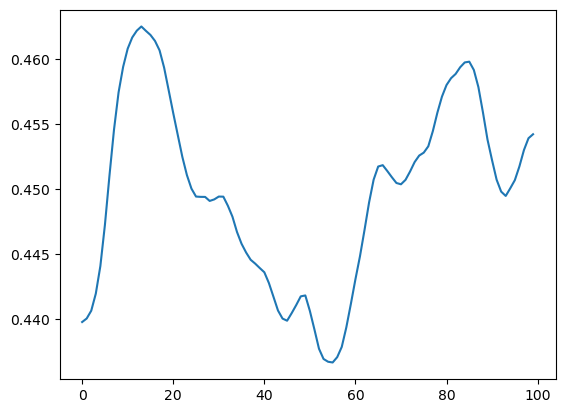

In [597]:
plt.Figure(figsize=(7,5))
plt.plot(tau, sigma2)
plt.show

## Generate Synthetic Microstructure from Gaussian Random Field

Given:
- `lambda_1`: threshold for pore phase
- `Rho_X_value`: covariance function

We can generate a new microstructure with similar statistical properties using the **spectral method**.

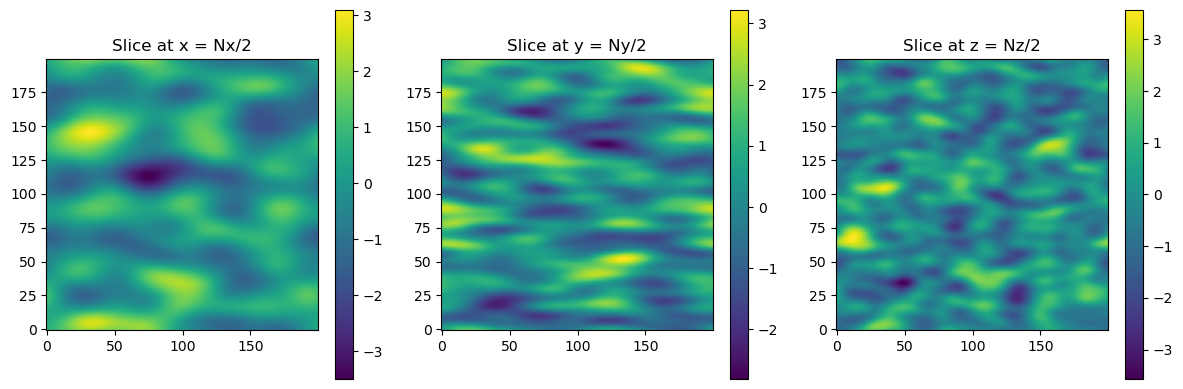

In [674]:
# -----------------------------
# Grid size
# -----------------------------
Nx, Ny, Nz = 200, 200, 200

# -----------------------------
# Correlation lengths (anisotropic)
# -----------------------------
ell_x, ell_y, ell_z = 5.0, 10.0, 20.0   # different correlation lengths in x, y, z

# -----------------------------
# Frequency grid
# -----------------------------
kx = fftfreq(Nx)
ky = fftfreq(Ny)
kz = fftfreq(Nz)
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')

# Squared magnitude of wavevector
K2 = (ell_x**2 * KX**2) + (ell_y**2 * KY**2) + (ell_z**2 * KZ**2)

# -----------------------------
# Power spectrum (anisotropic Gaussian kernel)
# -----------------------------
S = np.exp(-2 * np.pi**2 * K2)

# -----------------------------
# White noise
# -----------------------------
W = np.random.normal(size=(Nx, Ny, Nz))

# -----------------------------
# Gaussian random field
# -----------------------------
X = np.real(ifftn(np.sqrt(S) * fftn(W)))

# Normalize field
X = (X - X.mean()) / X.std()

# -----------------------------
# Visualization: 2D slices
# -----------------------------
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(X[Nx//2,:,:], origin='lower', cmap='viridis')
plt.title('Slice at x = Nx/2')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(X[:,Ny//2,:], origin='lower', cmap='viridis')
plt.title('Slice at y = Ny/2')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(X[:,:,Nz//2], origin='lower', cmap='viridis')
plt.title('Slice at z = Nz/2')
plt.colorbar()

plt.tight_layout()
plt.show()


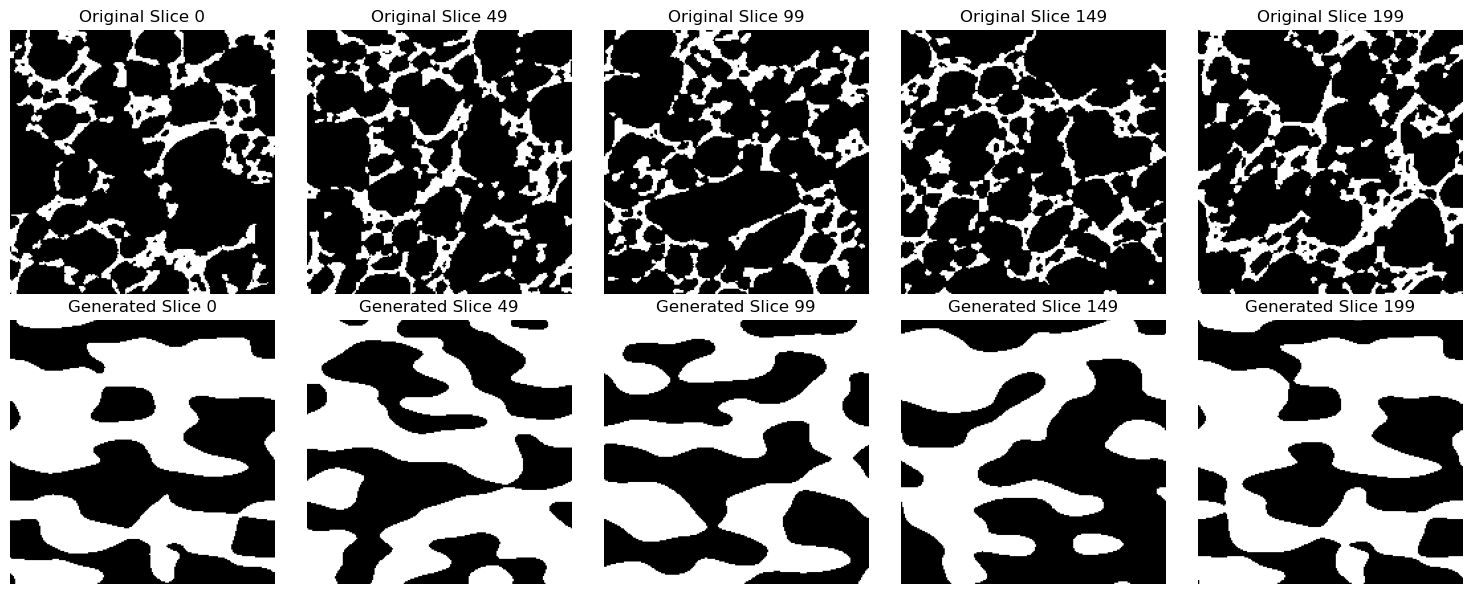

In [677]:
eps = 0.5
lambda_thr = norm.ppf(eps)
microstructure = (X > lambda_thr).astype(np.uint8)

# -----------------------------
# 4️⃣ Compare slices: generated vs original
# -----------------------------
n_slices_to_show = 5
indices = np.linspace(0, microstructure.shape[0]-1, n_slices_to_show, dtype=int)

plt.figure(figsize=(15, 6))  # taller figure for two rows

for i, idx in enumerate(indices):
    # Original microstructure
    plt.subplot(2, n_slices_to_show, i+1)
    plt.imshow(I_solid[idx], cmap='gray')
    plt.title(f"Original Slice {idx}")
    plt.axis('off')

    # Generated microstructure
    plt.subplot(2, n_slices_to_show, i+1+n_slices_to_show)
    plt.imshow(microstructure[idx], cmap='gray')
    plt.title(f"Generated Slice {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()


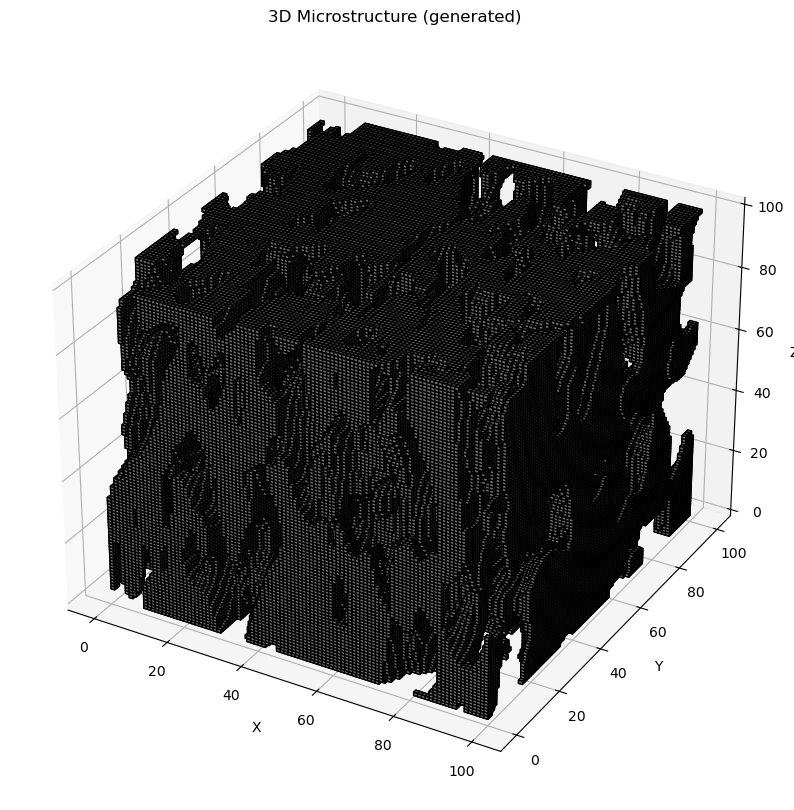

In [678]:
from mpl_toolkits.mplot3d import Axes3D  # optional in newer matplotlib

# microstructure: shape (Nx, Ny, Nz), binary 0/1

# Reduce resolution for visualization if the array is very large
step = 2  # skip every other voxel to reduce plotting cost
micro_small = microstructure[::step, ::step, ::step]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Colors: solid = gray, pores = white (or leave transparent)
ax.voxels(micro_small, facecolors='gray', edgecolor='k')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Microstructure (generated)')

plt.show()
